Tabu Search kết thúc sau 114 vòng lặp
Tour tốt nhất có chiều dài: 471
Thời gian thực thi: 0.07 giây

Chi tiết tour tốt nhất:
Thứ tự các thành phố: [16, 18, 4, 2, 6, 5, 12, 0, 14, 9, 17, 15, 13, 7, 3, 19, 10, 11, 1, 8]
Chiều dài tour: 471


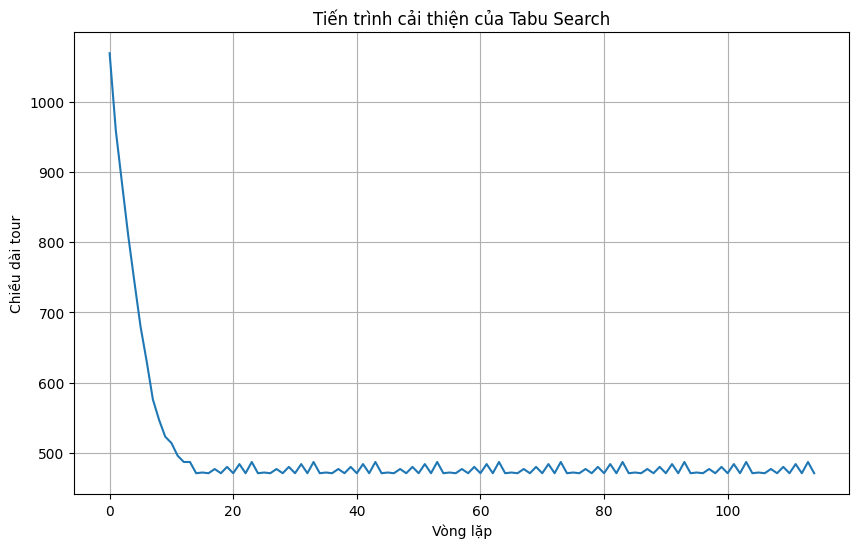

In [5]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

class TabuSearchTSP:
    def __init__(self, distance_matrix, tabu_tenure=10, max_iterations=100, max_no_improve=20):
        """
        Khởi tạo thuật toán Tabu Search cho bài toán TSP.
        
        Parameters:
        -----------
        distance_matrix : numpy.ndarray
            Ma trận khoảng cách giữa các thành phố
        tabu_tenure : int
            Số lượng vòng lặp mà một nước đi bị cấm (Tabu Tenure)
        max_iterations : int
            Số lượng vòng lặp tối đa
        max_no_improve : int
            Số lượng vòng lặp tối đa không cải thiện được lời giải tốt nhất
        """
        self.distance_matrix = distance_matrix
        self.num_cities = distance_matrix.shape[0]
        self.tabu_tenure = tabu_tenure
        self.max_iterations = max_iterations
        self.max_no_improve = max_no_improve
        
        # Khởi tạo ma trận tabu (để lưu thông tin cấm)
        self.tabu_matrix = np.zeros((self.num_cities, self.num_cities), dtype=int)
    
    def generate_initial_solution(self):
        """
        Tạo một lời giải ban đầu ngẫu nhiên (một tour đơn giản).
        
        Returns:
        --------
        list
            Một danh sách chứa thứ tự các thành phố (tour)
        """
        cities = list(range(self.num_cities))
        random.shuffle(cities)
        return cities
    
    def calculate_tour_length(self, tour):
        """
        Tính tổng chiều dài của một tour.
        
        Parameters:
        -----------
        tour : list
            Danh sách chứa thứ tự các thành phố
            
        Returns:
        --------
        float
            Tổng chiều dài của tour
        """
        tour_length = 0
        for i in range(len(tour)):
            tour_length += self.distance_matrix[tour[i]][tour[(i + 1) % len(tour)]]
        return tour_length
    
    def apply_2opt_move(self, tour, i, j):
        """
        Áp dụng phép toán 2-opt trên tour.
        
        Parameters:
        -----------
        tour : list
            Danh sách chứa thứ tự các thành phố
        i, j : int
            Các chỉ số để thực hiện phép toán 2-opt
            
        Returns:
        --------
        list
            Tour mới sau khi áp dụng phép toán 2-opt
        """
        # Tạo tour mới bằng cách đảo ngược đoạn từ i+1 đến j
        new_tour = tour[:i+1] + tour[j:i:-1] + tour[j+1:]
        return new_tour
    
    def get_best_move(self, current_tour, current_iteration):
        """
        Tìm nước đi tốt nhất (2-opt move) từ lời giải hiện tại.
    
        Parameters:
        -----------
        current_tour : list
            Tour hiện tại
        current_iteration : int
            Vòng lặp hiện tại
        
        Returns:
        --------
        tuple
            (i, j, new_tour, improvement) - các chỉ số i, j để thực hiện 2-opt,
            tour mới và mức độ cải thiện
        """
        current_length = self.calculate_tour_length(current_tour)
        best_improvement = 0
        best_move = None
        best_new_tour = None
    
        # Xét tất cả các cặp cạnh có thể hoán đổi
        for i in range(self.num_cities - 2):
            for j in range(i + 2, self.num_cities - (0 if i > 0 else 1)):
                # Các thành phố trong cạnh hiện tại
                a, b = current_tour[i], current_tour[i + 1]
                c, d = current_tour[j], current_tour[(j + 1) % self.num_cities]
            
                # Tính mức độ cải thiện khi thay đổi từ (a,b), (c,d) thành (a,c), (b,d)
                potential_improvement = (
                    self.distance_matrix[a][b] + self.distance_matrix[c][d] -
                    self.distance_matrix[a][c] - self.distance_matrix[b][d]
                )
            
                # Kiểm tra nếu nước đi là tabu, và không thỏa mãn aspiration criterion
                is_tabu = (self.tabu_matrix[a][b] > current_iteration or 
                        self.tabu_matrix[c][d] > current_iteration)
            
                # Aspiration criterion: chấp nhận nước đi tabu nếu nó đem lại cải thiện
                # lớn hơn so với mức cải thiện tốt nhất đã tìm thấy
                if is_tabu and potential_improvement <= best_improvement:
                    continue
            
                # Nếu nước đi cải thiện hơn nước đi tốt nhất hiện tại
                if potential_improvement > best_improvement:
                    best_improvement = potential_improvement
                    best_move = (i, j)
                    best_new_tour = self.apply_2opt_move(current_tour, i, j)
    
        # Nếu không tìm thấy nước đi cải thiện, chọn nước đi làm xấu đi ít nhất
        if best_move is None:
            worst_deterioration = float('inf')
            for i in range(self.num_cities - 2):
                for j in range(i + 2, self.num_cities - (0 if i > 0 else 1)):
                    a, b = current_tour[i], current_tour[i + 1]
                    c, d = current_tour[j], current_tour[(j + 1) % self.num_cities]
                
                    # Kiểm tra trạng thái tabu
                    if self.tabu_matrix[a][b] > current_iteration or self.tabu_matrix[c][d] > current_iteration:
                        continue
                
                    # Tính mức độ làm xấu đi
                    deterioration = (
                        self.distance_matrix[a][c] + self.distance_matrix[b][d] -
                        self.distance_matrix[a][b] - self.distance_matrix[c][d]
                    )
                
                    if deterioration < worst_deterioration:
                        worst_deterioration = deterioration
                        best_move = (i, j)
                        best_new_tour = self.apply_2opt_move(current_tour, i, j)
                        best_improvement = -worst_deterioration
    
        # Kiểm tra nếu best_move vẫn là None sau tất cả các bước
        if best_move is None:
            return -1, -1, None, 0
        else:
            return best_move[0], best_move[1], best_new_tour, best_improvement
    
    def update_tabu_list(self, tour, i, j, current_iteration):
        """
        Cập nhật danh sách Tabu sau khi thực hiện một nước đi.
        
        Parameters:
        -----------
        tour : list
            Tour hiện tại
        i, j : int
            Các chỉ số đã thực hiện phép toán 2-opt
        current_iteration : int
            Vòng lặp hiện tại
        """
        # Xác định các cạnh bị xóa
        a, b = tour[i], tour[i + 1]
        c, d = tour[j], tour[(j + 1) % len(tour)]
        
        # Cấm thêm lại các cạnh vừa bị xóa trong tabu_tenure vòng lặp tiếp theo
        self.tabu_matrix[a][b] = current_iteration + self.tabu_tenure
        self.tabu_matrix[b][a] = current_iteration + self.tabu_tenure
        self.tabu_matrix[c][d] = current_iteration + self.tabu_tenure
        self.tabu_matrix[d][c] = current_iteration + self.tabu_tenure
    
    def run(self):
        """
        Chạy thuật toán Tabu Search.
        
        Returns:
        --------
        tuple
            (best_tour, best_length, iterations, no_improve_count, history) - 
            tour tốt nhất, chiều dài tốt nhất, số vòng lặp đã chạy,
            số vòng lặp không cải thiện, và lịch sử độ dài tour
        """
        start_time = time.time()
        
        # Khởi tạo lời giải
        current_tour = self.generate_initial_solution()
        best_tour = current_tour.copy()
        current_length = self.calculate_tour_length(current_tour)
        best_length = current_length
        
        # Biến theo dõi
        iteration = 0
        no_improve_count = 0
        history = [best_length]
        
        # Vòng lặp chính
        while iteration < self.max_iterations and no_improve_count < self.max_no_improve:
            # Tìm nước đi tốt nhất
            i, j, new_tour, improvement = self.get_best_move(current_tour, iteration)
            
            if new_tour:
                # Cập nhật danh sách Tabu
                self.update_tabu_list(current_tour, i, j, iteration)
                
                # Cập nhật tour hiện tại
                current_tour = new_tour
                current_length = self.calculate_tour_length(current_tour)
                
                # Cập nhật tour tốt nhất nếu cần
                if current_length < best_length:
                    best_tour = current_tour.copy()
                    best_length = current_length
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                
                history.append(current_length)
            else:
                # Không tìm thấy nước đi hợp lệ
                no_improve_count += 1
            
            iteration += 1
        
        end_time = time.time()
        execution_time = end_time - start_time
        
        print(f"Tabu Search kết thúc sau {iteration} vòng lặp")
        print(f"Tour tốt nhất có chiều dài: {best_length}")
        print(f"Thời gian thực thi: {execution_time:.2f} giây")
        
        return best_tour, best_length, iteration, no_improve_count, history
    
    def plot_progress(self, history):
        """
        Vẽ đồ thị tiến trình cải thiện của thuật toán.
        
        Parameters:
        -----------
        history : list
            Danh sách chiều dài tour qua các vòng lặp
        """
        plt.figure(figsize=(10, 6))
        plt.plot(history)
        plt.title('Tiến trình cải thiện của Tabu Search')
        plt.xlabel('Vòng lặp')
        plt.ylabel('Chiều dài tour')
        plt.grid(True)
        plt.show()

# Hàm tạo ma trận khoảng cách ngẫu nhiên cho việc thử nghiệm
def generate_random_distance_matrix(num_cities):
    """
    Tạo ma trận khoảng cách ngẫu nhiên cho num_cities thành phố.
    Ma trận là đối xứng và có đường chéo chính bằng 0.
    """
    # Tạo ma trận đối xứng
    matrix = np.random.randint(1, 100, size=(num_cities, num_cities))
    # Đảm bảo ma trận đối xứng
    matrix = (matrix + matrix.T) // 2
    # Đảm bảo đường chéo chính bằng 0
    np.fill_diagonal(matrix, 0)
    return matrix

# Ví dụ sử dụng
if __name__ == "__main__":
    # Tạo một ma trận khoảng cách ngẫu nhiên cho 20 thành phố
    num_cities = 20
    distance_matrix = generate_random_distance_matrix(num_cities)
    
    # Khởi tạo và chạy thuật toán Tabu Search
    ts = TabuSearchTSP(
        distance_matrix=distance_matrix,
        tabu_tenure=10,
        max_iterations=1000,
        max_no_improve=100
    )
    
    best_tour, best_length, iterations, no_improve_count, history = ts.run()
    
    # In kết quả
    print("\nChi tiết tour tốt nhất:")
    print(f"Thứ tự các thành phố: {best_tour}")
    print(f"Chiều dài tour: {best_length}")
    
    # Vẽ đồ thị tiến trình
    ts.plot_progress(history)

 

Tabu Search kết thúc sau 21 vòng lặp
Tour tốt nhất có chiều dài: 100
Thời gian thực thi: 0.00 giây

Kết quả:
Thứ tự các thành phố tốt nhất: [0, 1, 4, 2, 3]
Chiều dài tour tốt nhất: 100
Số vòng lặp đã thực hiện: 21
Số vòng lặp không cải thiện trước khi dừng: 20


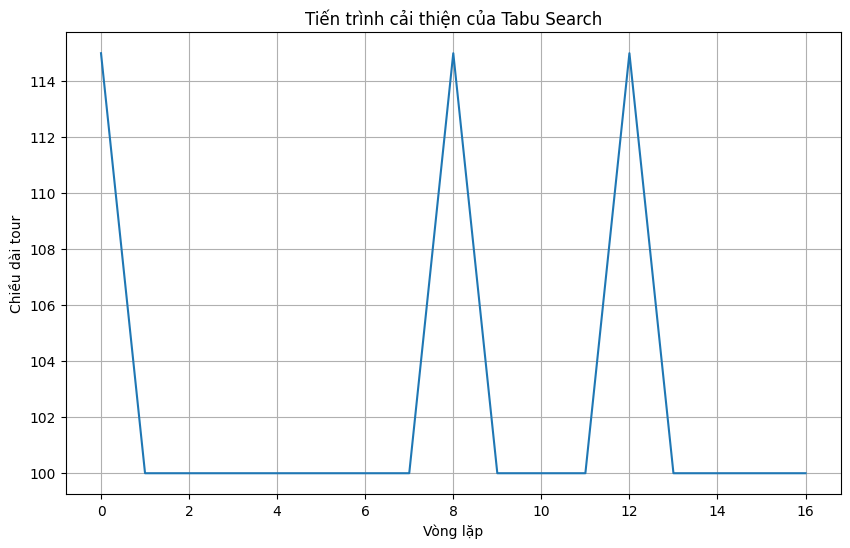

In [6]:
# Tạo một ví dụ TSP nhỏ với 5 thành phố
distance_matrix = np.array([
    [0, 10, 15, 20, 25],
    [10, 0, 35, 25, 30],
    [15, 35, 0, 30, 10],
    [20, 25, 30, 0, 40],
    [25, 30, 10, 40, 0]
])

# Khởi tạo và chạy thuật toán Tabu Search
ts = TabuSearchTSP(
    distance_matrix=distance_matrix,
    tabu_tenure=5,  # Tabu Tenure nhỏ hơn cho ví dụ nhỏ
    max_iterations=100,
    max_no_improve=20
)

best_tour, best_length, iterations, no_improve_count, history = ts.run()

print("\nKết quả:")
print(f"Thứ tự các thành phố tốt nhất: {best_tour}")
print(f"Chiều dài tour tốt nhất: {best_length}")
print(f"Số vòng lặp đã thực hiện: {iterations}")
print(f"Số vòng lặp không cải thiện trước khi dừng: {no_improve_count}")

# Vẽ đồ thị tiến trình
ts.plot_progress(history)